In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
%matplotlib inline

In [17]:
oldfits = fits.open('UPS_map_SNR_360x41.fits')
psffits = fits.open('psc_model_0.5deg_180x41_pixelcenter.fits')
im = oldfits[0].data[0]

E = np.logspace(np.log10(0.2),np.log10(500),30)
print E
arr = np.zeros_like(oldfits[0].data)
for ie in range(arr.shape[0]):
    arr[ie,:,:] = im*(E[ie]/E[6])**-2.2 ##Was normalized to the flux at 1 GeV

[  2.00000000e-01   2.61939106e-01   3.43060476e-01   4.49304772e-01
   5.88452451e-01   7.70693545e-01   1.00937389e+00   1.32197247e+00
   1.73138144e+00   2.26758253e+00   2.96984270e+00   3.88958971e+00
   5.09417825e+00   6.67182248e+00   8.73805608e+00   1.14441930e+01
   1.49884084e+01   1.96302515e+01   2.57096526e+01   3.36718170e+01
   4.40998283e+01   5.77573479e+01   7.56445404e+01   9.90713164e+01
   1.29753260e+02   1.69937265e+02   2.22566076e+02   2.91493795e+02
   3.81768120e+02   5.00000000e+02]


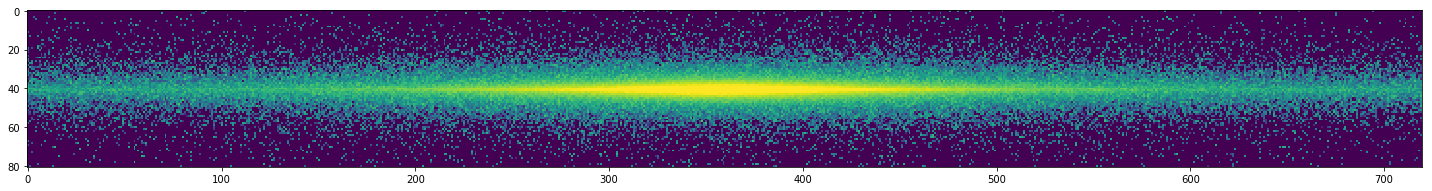

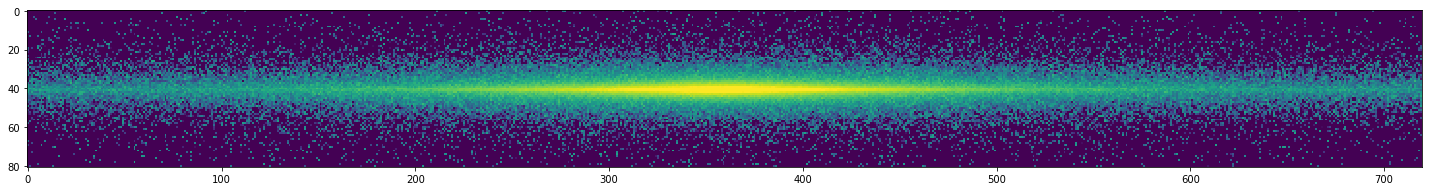

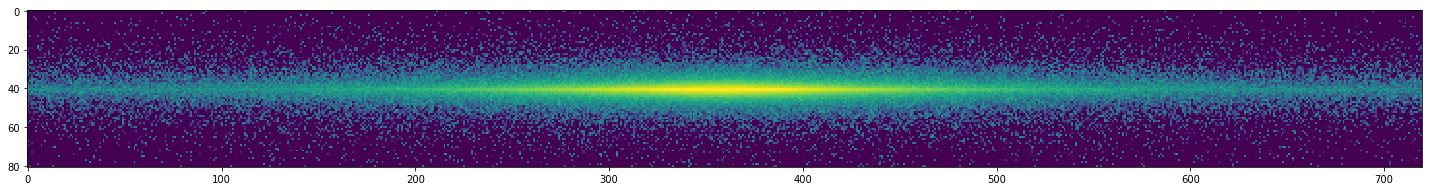

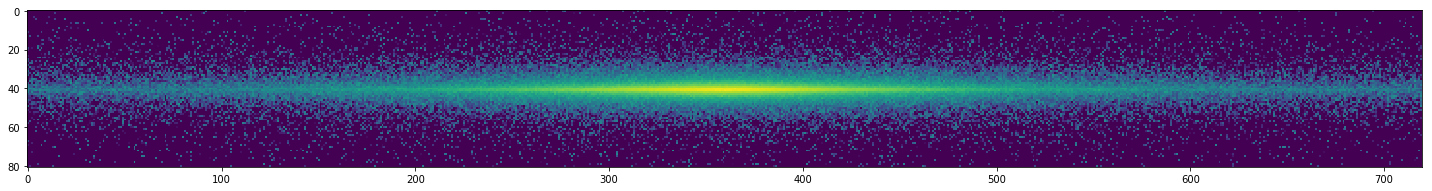

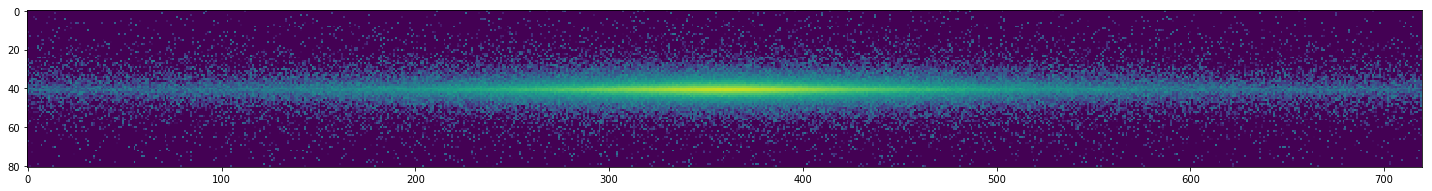

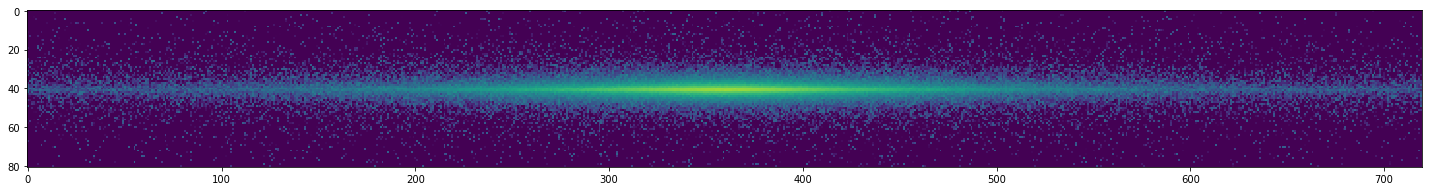

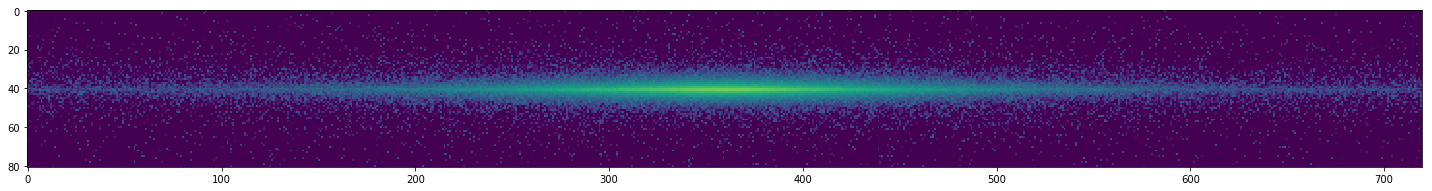

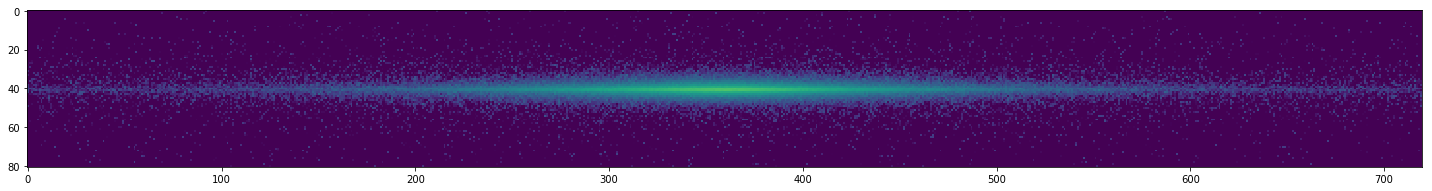

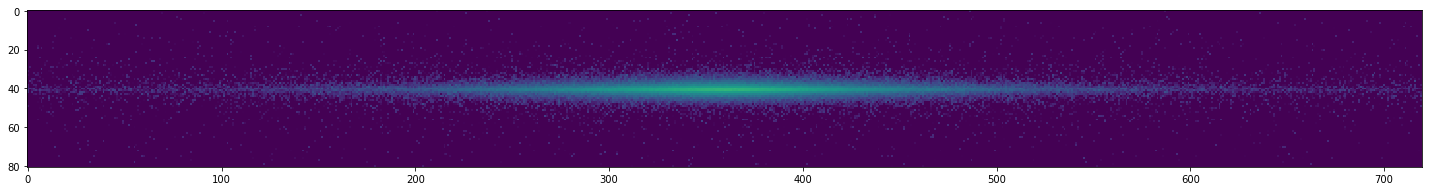

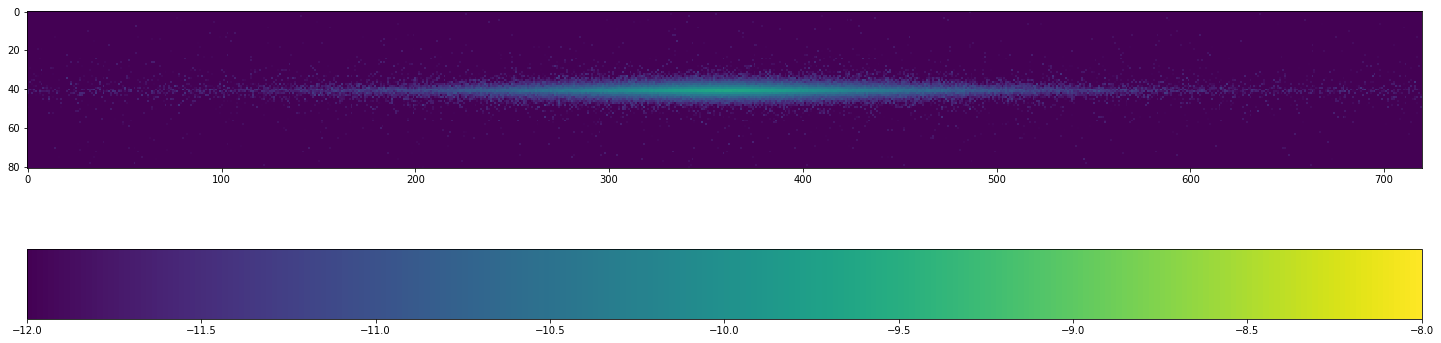

In [3]:
for i in range(10):
    plt.figure(figsize=(25,10))
    plt.imshow(np.log10(arr[i]),vmin=-12,vmax=-8)
plt.colorbar(orientation='horizontal')

In [11]:
# Convolve with kernel PSF
data = psffits[0].data
from scipy import ndimage
kernels = np.array([d[25:56,164:195] for d in data])
cutoff = 0.00001
norms = kernels.sum(axis=1).sum(axis=1)
kernels = (kernels.T/norms).T
kernels[kernels<cutoff] = 0
norms = kernels.sum(axis=1).sum(axis=1)
kernels = (kernels.T/norms).T

new_arr = np.zeros_like(arr)

for ie in range(len(E)):
    new_arr[ie,:,:]=ndimage.convolve(arr[ie],kernels[ie])
    

4.60383606438e-05 4.60383638456e-05


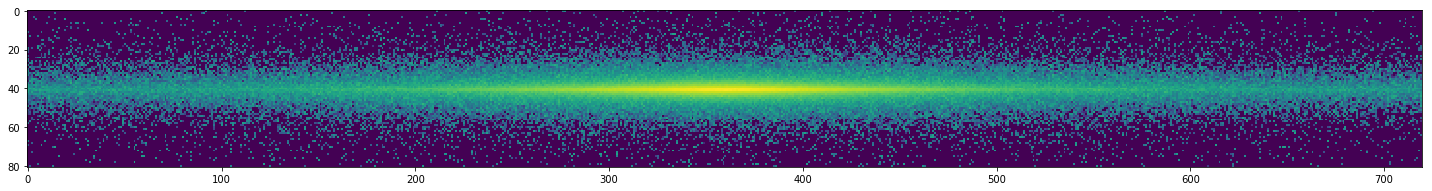

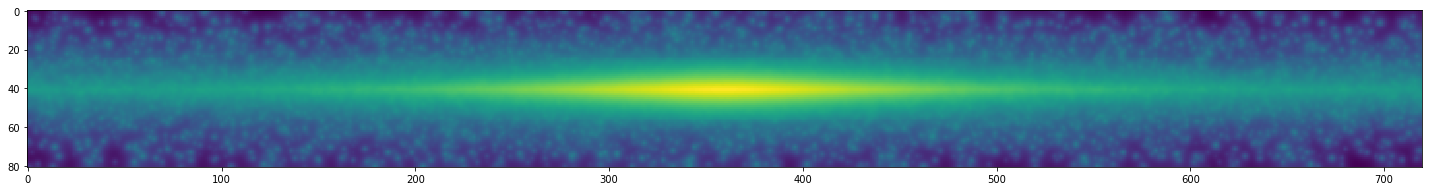

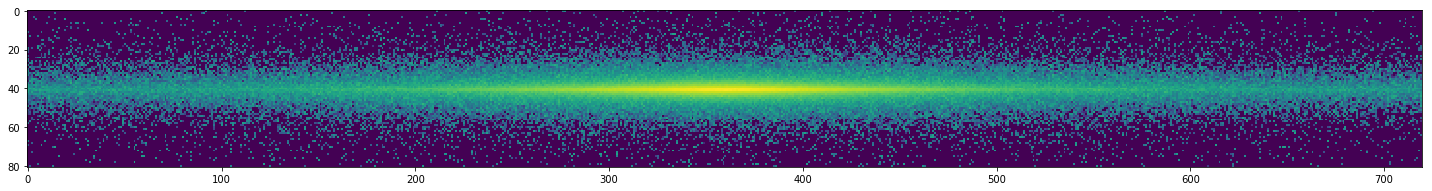

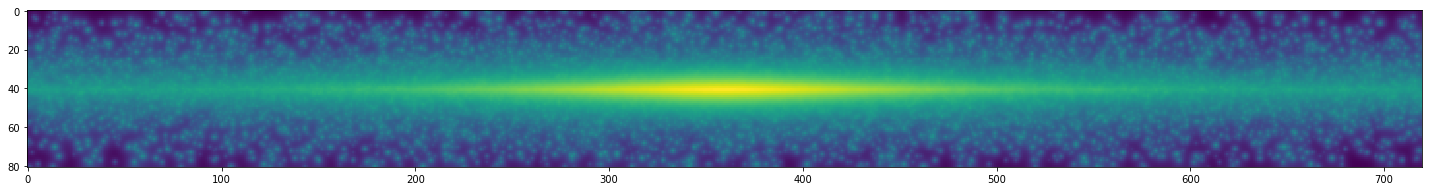

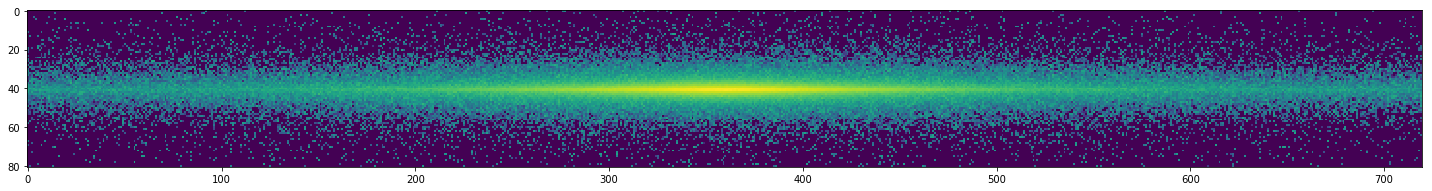

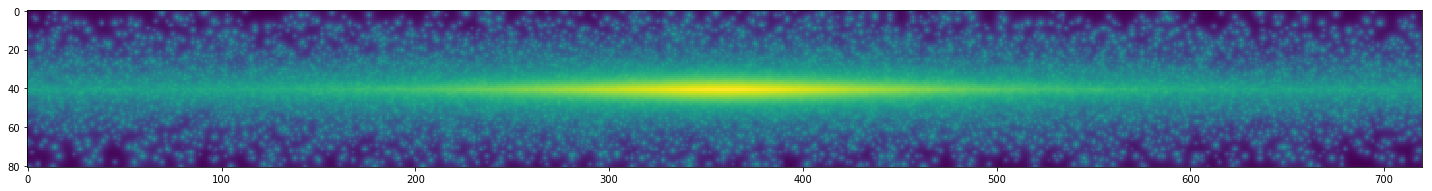

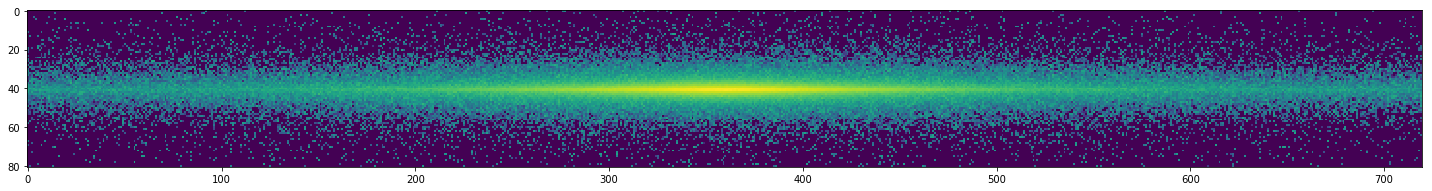

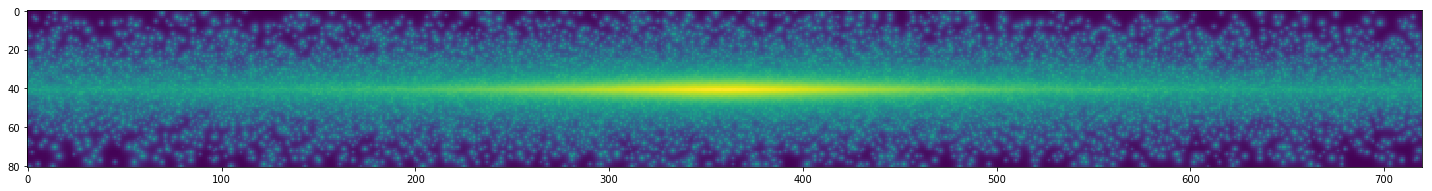

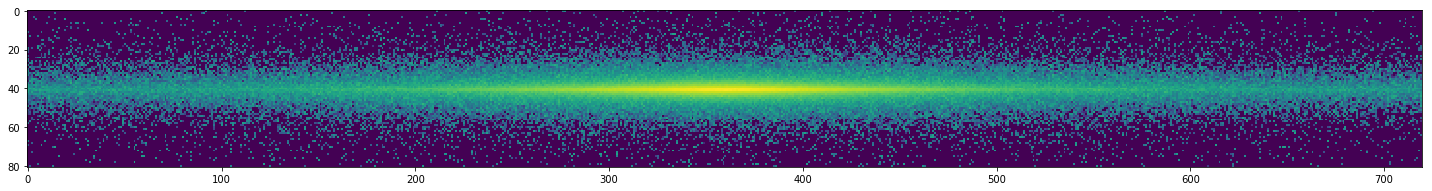

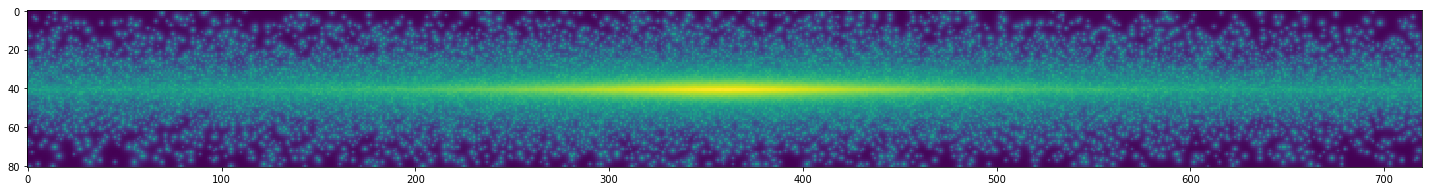

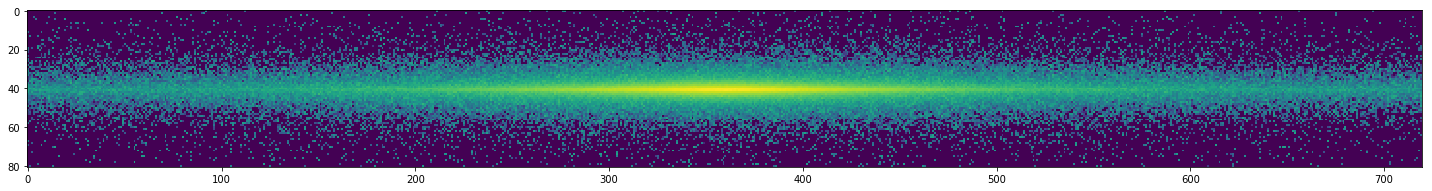

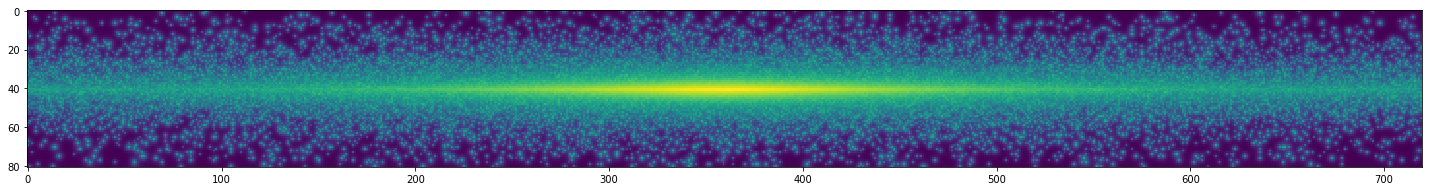

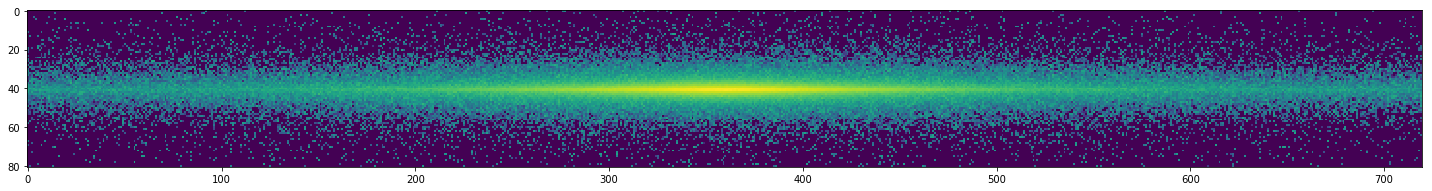

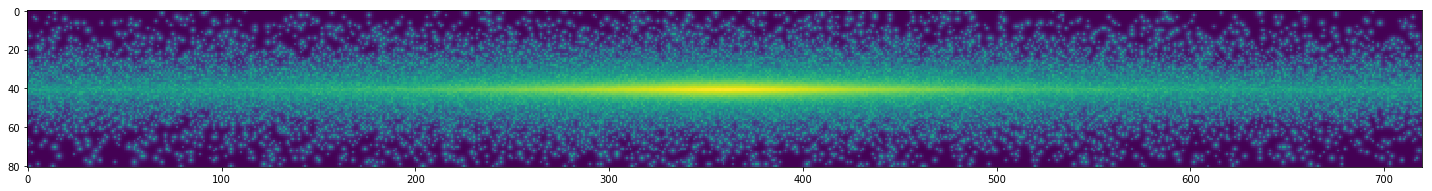

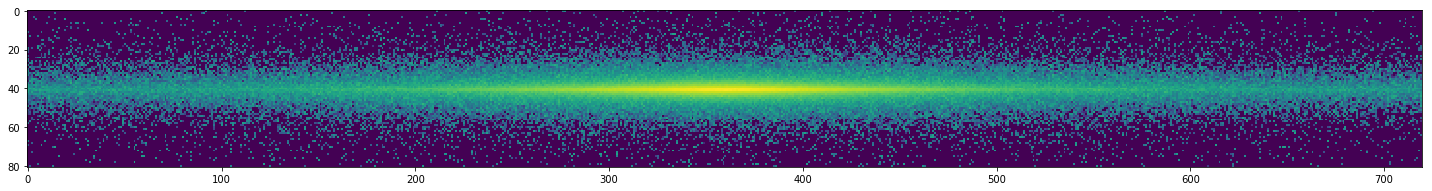

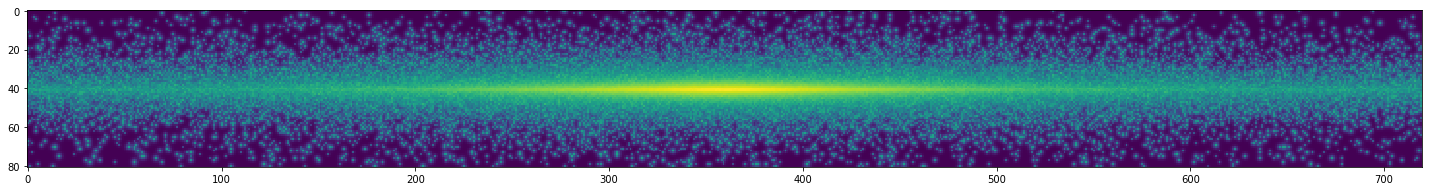

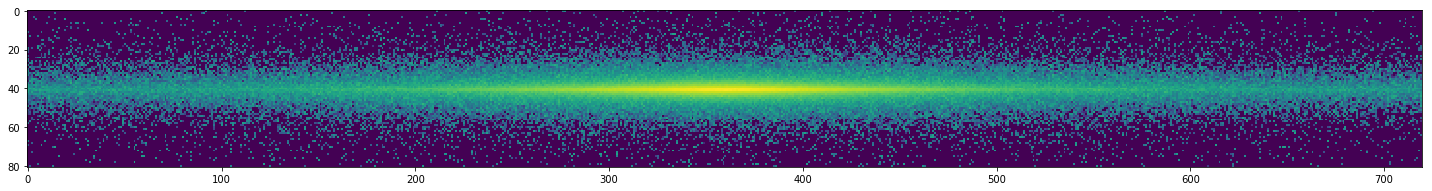

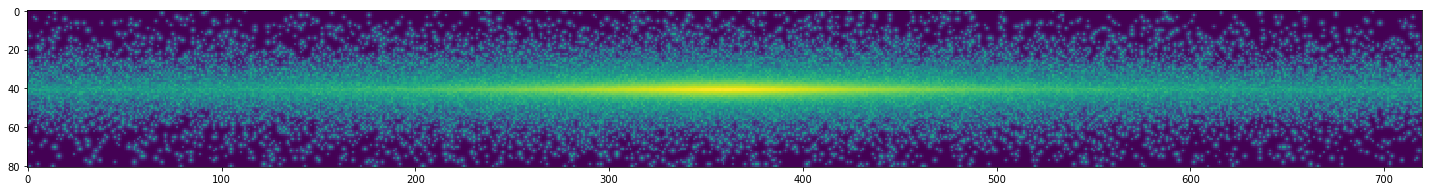

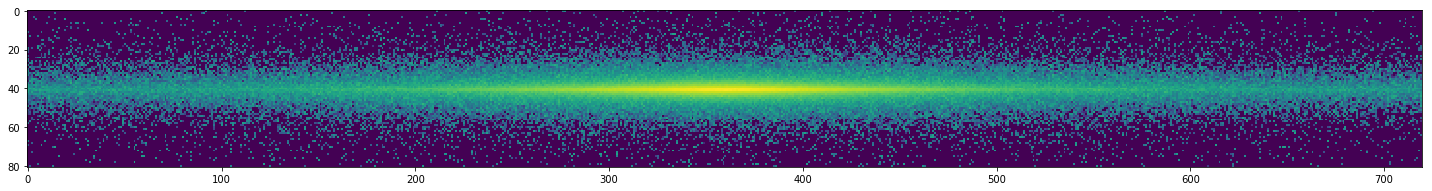

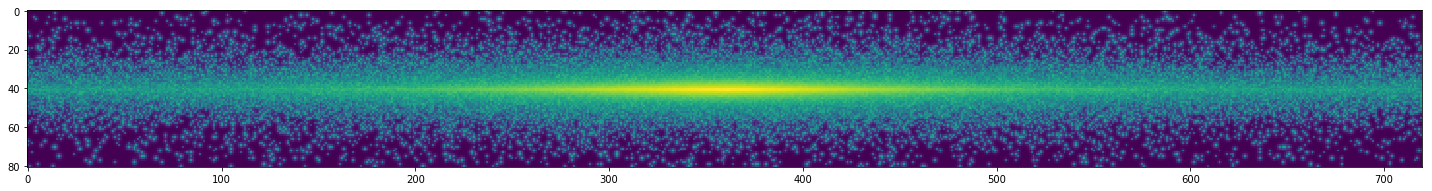

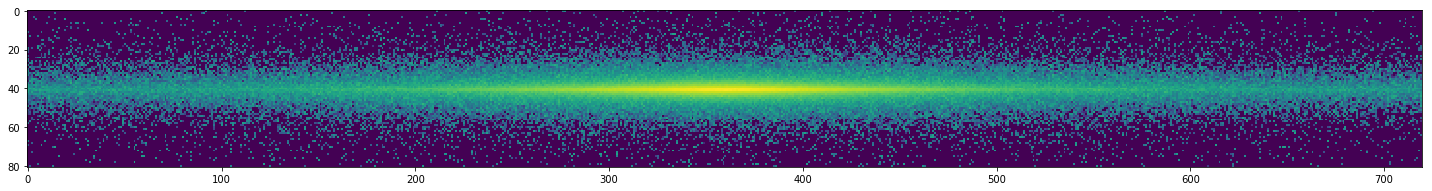

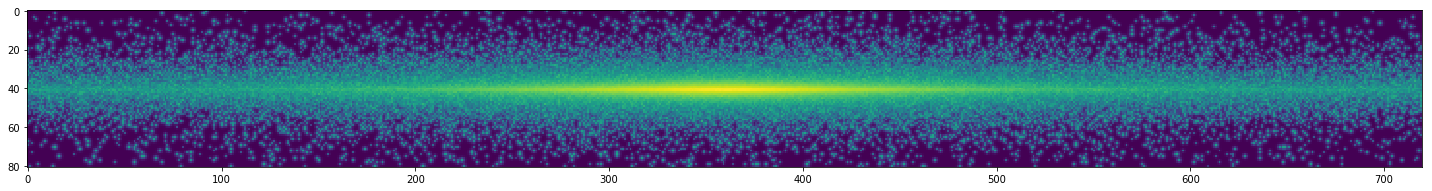

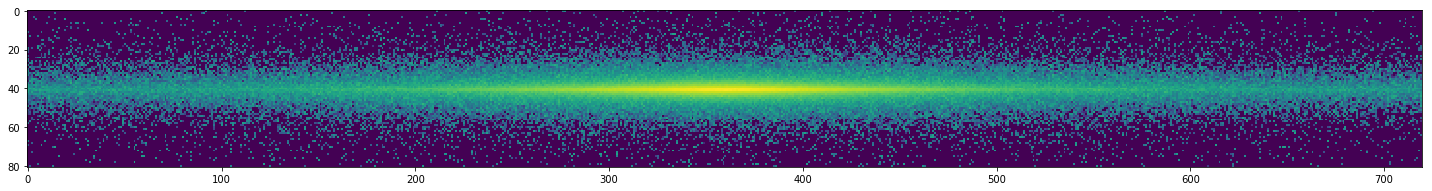

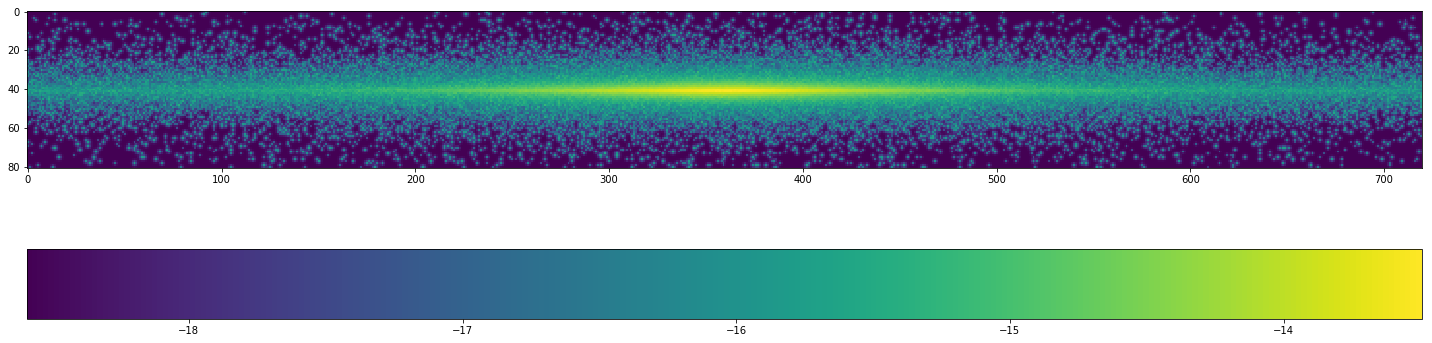

In [18]:
#Compare non smoothed with smoothed
for i in np.arange(2,26,2):
    plt.figure(figsize=(25,10))
    plt.imshow(np.log10(arr[i]))
    plt.figure(figsize=(25,10))
    plt.imshow(np.log10(new_arr[i]))
    
plt.colorbar(orientation='horizontal')
print np.sum(arr), np.sum(new_arr) #same total flux?

In [15]:
prihdr = fits.Header()
prihdr['COMMENT'] = 'Unresolved PS 360x41'
prihdu = fits.PrimaryHDU(data=new_arr, header=prihdr)
tbhdu = fits.BinTableHDU(oldfits[1].data)
hdulist = fits.HDUList([prihdu,tbhdu])
hdulist.writeto('UPS_PSF_SNR_360x41.fits',overwrite=True)

In [ ]:
def deltap(pprime,p):
    return 2*np.arcsin((pprime-p)/2.)

def x(dp,Sp):
    return dp/Sp

def SP(E):
    c0 = 6.38e-2
    c1 = 1.26e-3
    beta = 0.8
    part1 = c0*(E/0.1)**-beta
    return np.sqrt(part1*part1+c1*c1)

def kings(x,sigma,y):
    part1 = 1./(2*np.pi*sigma*sigma)
    part2 = 1.-1./gamma
    part3 = 1.+x*x/(2*gamma*sigma*sigma)
    return part1*part2*part3**-gamma

##???